In [156]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

In [157]:
df = pd.read_csv('Gia SMP va SMPcap 2021(Giá thị trường SMP).csv', encoding="latin-1", delimiter=';')
df= df.set_index('Ngày')

In [191]:
data = df[['2']]
data

,2
Ngày,
01/01/2021,964.4
01/02/2021,1019.7
01/03/2021,988.4
01/04/2021,1002.0
01/05/2021,1061.5
...,...
27/12/2021,1002.0
28/12/2021,1002.0
29/12/2021,1061.5


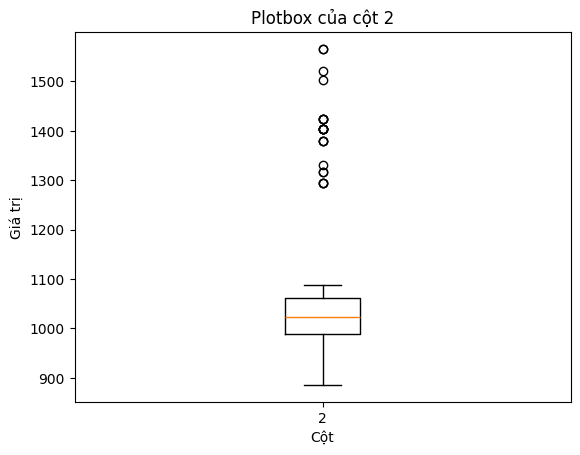

In [194]:
plt.boxplot(data['2'], labels=['2'])
plt.xlabel('Cột')
plt.ylabel('Giá trị')
plt.title('Plotbox của cột 2')
plt.show()

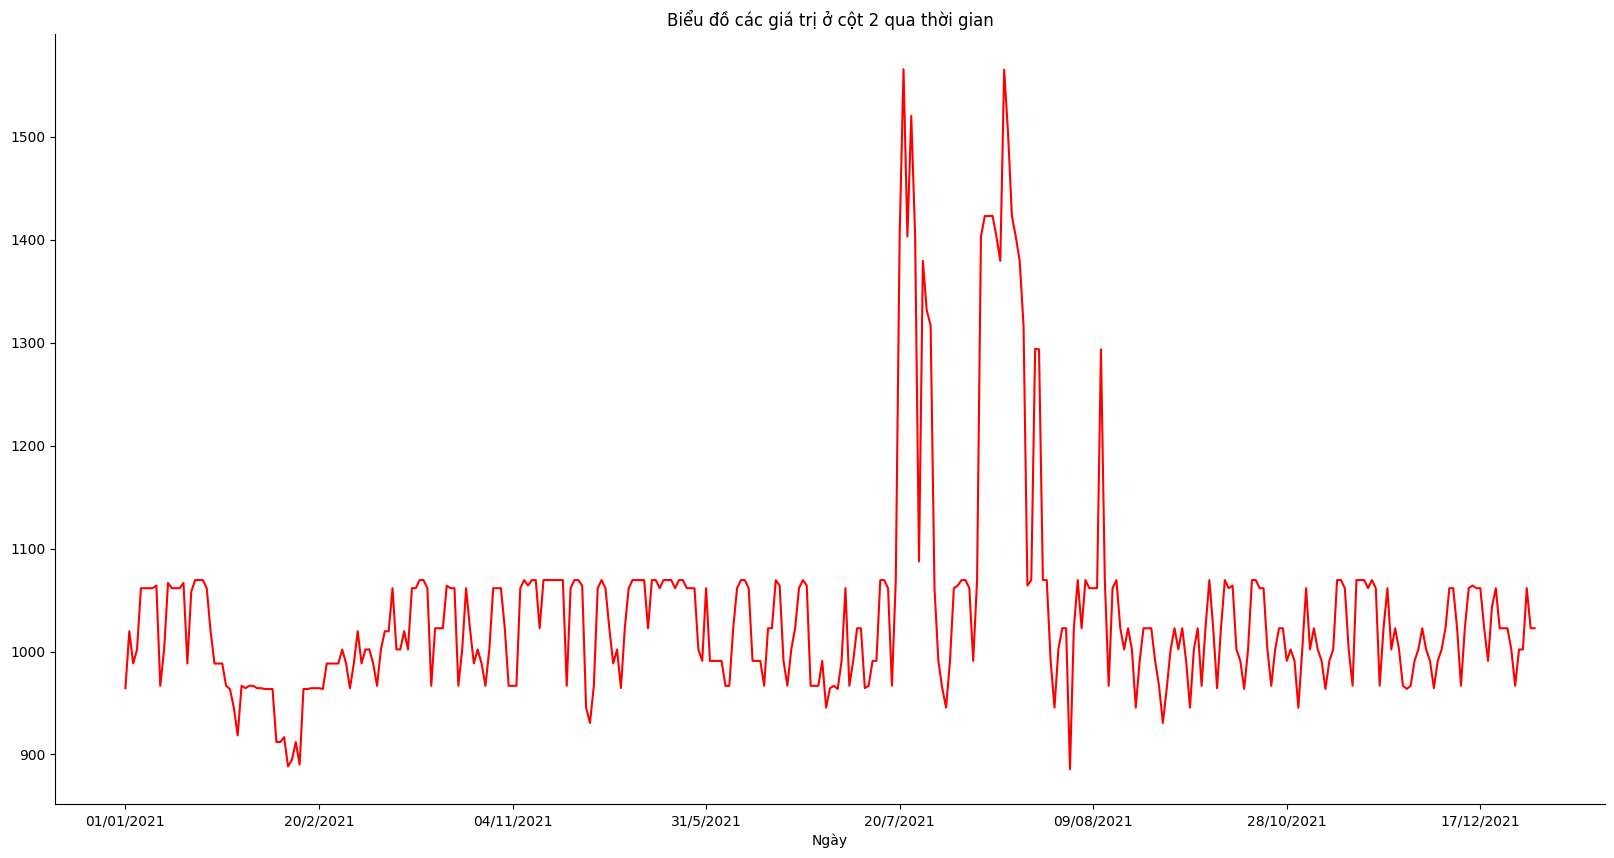

In [160]:
plt.figure(figsize=(20,10))
df['2'].plot(kind = 'line',title="Biểu đồ các giá trị ở cột 2 qua thời gian", color='red')
plt.gca().spines[['top','right']].set_visible(False)

ScatterMatrix

B1: Sử dụng HMM để dự đoán giá trong 30 ngày tiếp theo

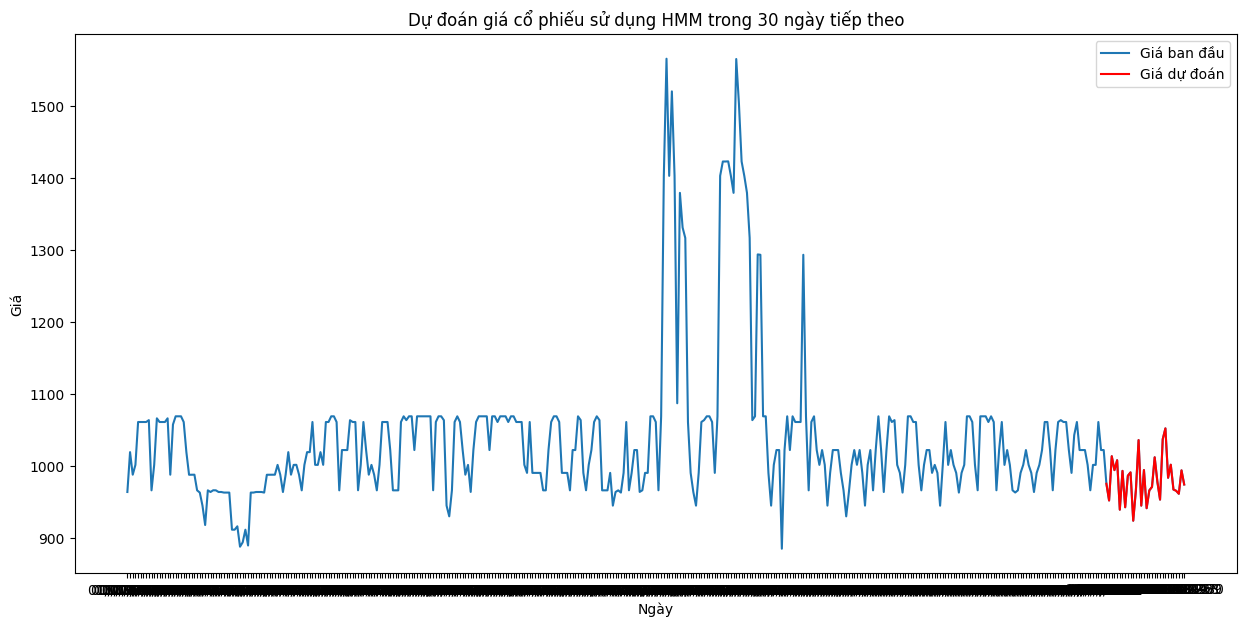

In [198]:
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt

# Giả sử cột chứa giá cổ phiếu có tên là '2'
stock_prices = data['2'].values.reshape(-1, 1)  # Thay '2' bằng tên cột chính xác

# Huấn luyện mô hình HMM
hmm_model = GaussianHMM(n_components=4, covariance_type='diag', n_iter=1000)
hmm_model.fit(stock_prices)

# Dự đoán giá cổ phiếu cho 30 ngày tiếp theo
num_days_to_predict = 30
predicted_prices = []

# Khởi tạo giá trị dự đoán từ giá cuối cùng trong dữ liệu huấn luyện
last_price = stock_prices[-1]

for i in range(num_days_to_predict):
    # Sử dụng giá trị cuối cùng của stock_prices để dự đoán hidden state
    hidden_state = hmm_model.predict(last_price.reshape(1, -1))[-1]
    # Tạo giá dự đoán tiếp theo dựa trên hidden state
    next_price = hmm_model.means_[hidden_state][0] + np.sqrt(hmm_model.covars_[hidden_state][0]) * np.random.randn()
    predicted_prices.append(next_price)
    # Cập nhật last_price để dùng cho lần dự đoán tiếp theo
    last_price = np.array([[next_price]])

# Lấy ngày cuối cùng trong dữ liệu lịch sử
last_date = df.index[-1]

# Tạo các thời điểm mới cho dữ liệu dự đoán
future_dates = pd.date_range(start=last_date, periods=len(predicted_prices) + 1, inclusive='right')

# Tạo Series từ dữ liệu dự đoán và các thời điểm mới
predicted_series = pd.Series(predicted_prices, index=future_dates, name='Predicted Prices')

# Chuyển đổi các giá trị của Series thành chuỗi ngày-tháng-năm
predicted_series.index = predicted_series.index.strftime('%Y-%m-%d')

# Thêm dữ liệu dự đoán vào DataFrame
df_predicted = pd.concat([df['2'], predicted_series])

# Vẽ biểu đồ
plt.figure(figsize=(15, 7))
plt.plot(df_predicted, label='Giá ban đầu')
plt.plot(predicted_series, color='red', label='Giá dự đoán')  # Dữ liệu dự đoán màu đỏ
plt.xlabel('Ngày')
plt.ylabel('Giá')
plt.title('Dự đoán giá cổ phiếu sử dụng HMM trong 30 ngày tiếp theo')
plt.legend()
plt.show()

Kalman

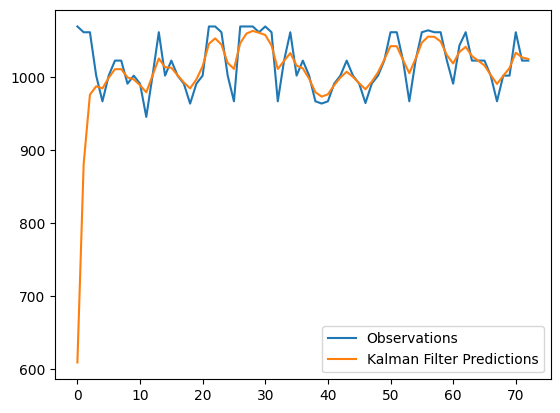

In [204]:
from pykalman import KalmanFilter
test_size = int(0.2 * len(data))

# Khởi tạo và huấn luyện bộ lọc Kalman
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
kf = kf.em(data.values[:-test_size], n_iter=10)

# Dự đoán với bộ lọc Kalman
state_means, state_covariances = kf.smooth(data.values[-test_size:])

# Vẽ biểu đồ
plt.plot(data.values[-test_size:], label='Observations')
plt.plot(state_means, label='Kalman Filter Predictions')
plt.legend()
plt.show()